# VAE

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
%matplotlib inline 
# %config InlineBackend.figure_format = 'retina'
print ("TF version: %s"%(tf.__version__))

TF version: 1.12.0


### Define VAE Calss

In [2]:
class VariationalAutoEncoderClass(object):
    """
    VAE implementation
    """
    def __init__(self,name='vae',xdim=784,zdim=16,
                 hdims_Q=[256]*2,hdims_P=[256]*2,actv_Q=tf.nn.relu,actv_P=tf.nn.relu,
                 actv_out=tf.nn.sigmoid,
                 var_max=np.inf,beta=1.0):
        self.name = name
        self.xdim = xdim
        self.zdim = zdim
        self.hdims_Q = hdims_Q
        self.hdims_P = hdims_P
        self.actv_Q = actv_Q
        self.actv_P = actv_P
        self.actv_out = actv_out
        self.var_max = var_max
        self.beta = beta
        with tf.variable_scope(self.name,reuse=False):
            self.build_graph()
            
    def build_graph(self):
        kernel_init = tf.truncated_normal_initializer(mean=0.0,stddev=0.1)
        bias_init = tf.constant_initializer(value=0.0)
        
        self.x_real = tf.placeholder(shape=[None,self.xdim],dtype=tf.float32,name='x_real') # input [n x x_dim]
        self.x_trgt = tf.placeholder(shape=[None,self.xdim],dtype=tf.float32,name='x_trgt') # target [n x x_dim]
        self.z_real = tf.placeholder(shape=[None,self.zdim],dtype=tf.float32,name='z_real') # z_real [n x z_dim]
        self.lr = tf.placeholder(shape=[],dtype=tf.float32,name='lr') # [1]
        self.n = tf.shape(self.x_real)[0] # number of batch
        
        # Encoder netowrk Q(z|x): x_real => z_sample
        with tf.variable_scope('Q',reuse=False):
            net = self.x_real
            for h_idx,hdim in enumerate(self.hdims_Q):
                net = tf.layers.dense(net,hdim,activation=self.actv_Q,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_Q_lin_%d'%(h_idx))
            self.z_mu = tf.layers.dense(net,self.zdim,activation=None,
                                        kernel_initializer=kernel_init,bias_initializer=bias_init,
                                        name='z_mu') # [n x z_dim]
            self.z_logvar = tf.layers.dense(net,self.zdim,activation=None,
                                            kernel_initializer=kernel_init,bias_initializer=bias_init,
                                            name='z_logvar') # [n x z_dim]
            if (self.var_max == np.inf): 
                self.z_var = tf.exp(self.z_logvar)
            else: 
                self.z_var = self.var_max*tf.sigmoid(self.z_logvar)
            # z-sample 
            self.eps = tf.random_normal((self.n,self.zdim),0.0,1.0,dtype=tf.float32)
            self.z_sample = self.z_mu + tf.sqrt(self.z_var+1e-6)*self.eps
            
        # Decoder netowrk P(x|z): z_sample => x_trgt
        with tf.variable_scope('P',reuse=False):
            net = self.z_sample
            for h_idx,hdim in enumerate(self.hdims_P):
                net = tf.layers.dense(net,hdim,activation=self.actv_P,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_P_lin_%d'%(h_idx))
            # Recon
            self.x_recon = tf.layers.dense(net,self.xdim,activation=self.actv_out,
                                           kernel_initializer=kernel_init,bias_initializer=bias_init,
                                           name='x_recon') # [n x x_dim]
            
        # Decoder netowrk P(x|z): z_real => x_decode
        with tf.variable_scope('P',reuse=True):
            net = self.z_real
            for h_idx,hdim in enumerate(self.hdims_P):
                net = tf.layers.dense(net,hdim,activation=self.actv_P,
                                      kernel_initializer=kernel_init,bias_initializer=bias_init,
                                      name='hid_P_lin_%d'%(h_idx))
            # Recon
            self.x_decode = tf.layers.dense(net,self.xdim,activation=self.actv_out,
                                            kernel_initializer=kernel_init,bias_initializer=bias_init,
                                            name='x_recon') # [n x x_dim]
        
        # Loss
        self.l1_losses = tf.reduce_sum(tf.abs(self.x_recon-self.x_trgt),axis=1) # [n] 
        self.l2_losses = tf.reduce_sum((self.x_recon-self.x_trgt)**2,axis=1) # [n] 
        self.recon_losses = self.l2_losses # [n]
        self.recon_loss = tf.reduce_mean(self.recon_losses) # [1]
        
        self.kl_losses = 0.5*( self.z_var + self.z_mu**2 - tf.log(self.z_var) - 1.0 ) 
        self.kl_losses = tf.reduce_sum(self.kl_losses,axis=1) # [n]
        self.kl_loss = self.beta*tf.reduce_mean(self.kl_losses) # [1]
        
        # Optimizer
        self.t_vars = [var for var in tf.trainable_variables() if '%s/'%(self.name) in var.name] 
        self.q_vars = [var for var in self.t_vars if '%s/Q'%(self.name) in var.name] # encoder 
        self.p_vars = [var for var in self.t_vars if '%s/P'%(self.name) in var.name] # encoder 
        self.ae_vars = self.q_vars + self.p_vars # both encoder and decoder
        self.optm_total = tf.train.AdamOptimizer(self.lr).minimize(
            self.recon_loss+self.kl_loss,var_list=self.ae_vars)
    
    def update(self,sess,x_batch,lr=1e-3):
        feed_dict = {self.x_real:x_batch,self.x_trgt:x_batch,self.lr:lr}
        _,recon_loss_val,kl_loss_val = sess.run(
            [self.optm_total,self.recon_loss,self.kl_loss],feed_dict=feed_dict)
        return recon_loss_val,kl_loss_val
print ("VAE class ready.")

VAE class ready.


### Train VAE with MNIST Data

In [3]:
def gpu_sess(): 
    config = tf.ConfigProto(); 
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    return sess    

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() 
x,y = X_train.reshape(60000,784)/255,Y_train
n = x.shape[0]
tf.reset_default_graph()
V = VariationalAutoEncoderClass(
    name='vae',xdim=784,zdim=2,
    hdims_Q=[256]*2,hdims_P=[256]*2,actv_Q=tf.nn.relu,actv_P=tf.nn.relu,
    actv_out=tf.nn.sigmoid,
    var_max=np.inf,beta=1.0)
sess = gpu_sess()
print ("[%s] instantiated."%(V.name))

[vae] instantiated.


[0/50] recon:[0.371] kl:[0.023].


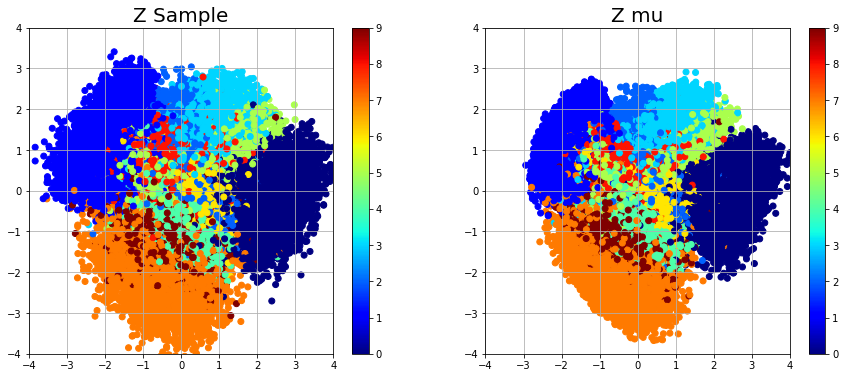

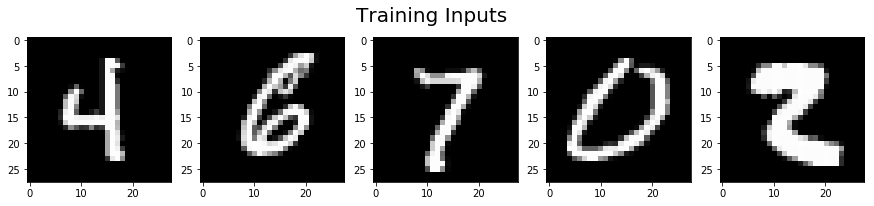

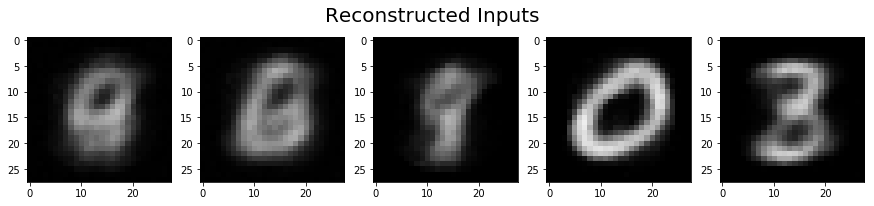

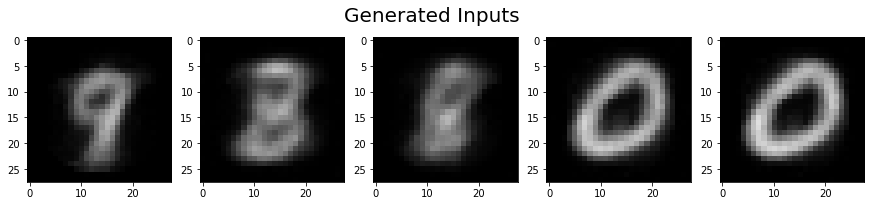

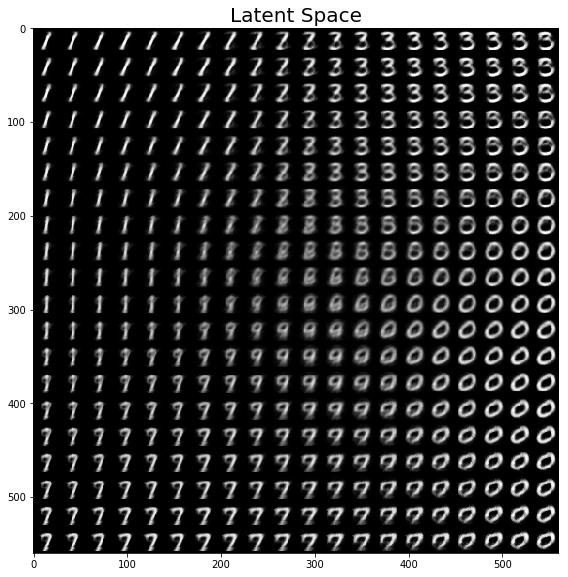

[1/50] recon:[0.302] kl:[0.026].
[2/50] recon:[0.289] kl:[0.029].
[3/50] recon:[0.280] kl:[0.031].
[4/50] recon:[0.273] kl:[0.032].
[5/50] recon:[0.267] kl:[0.033].


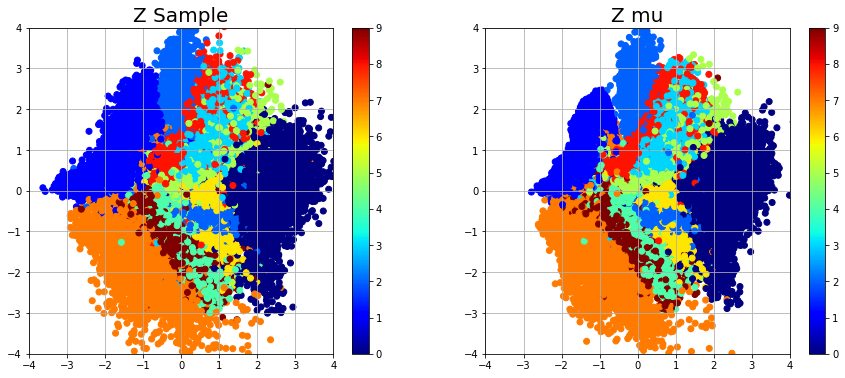

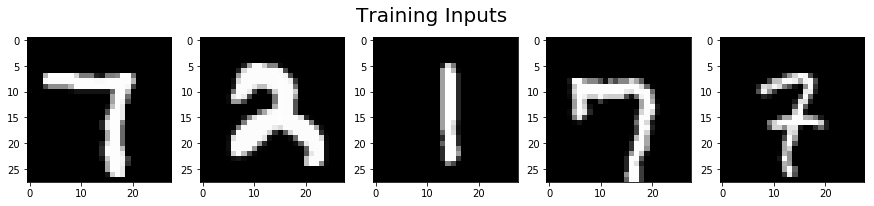

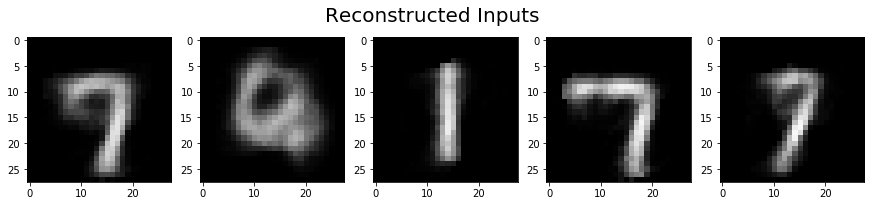

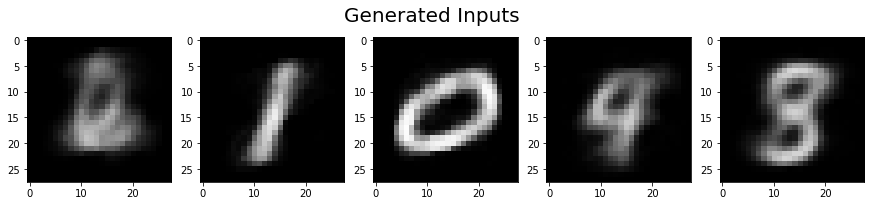

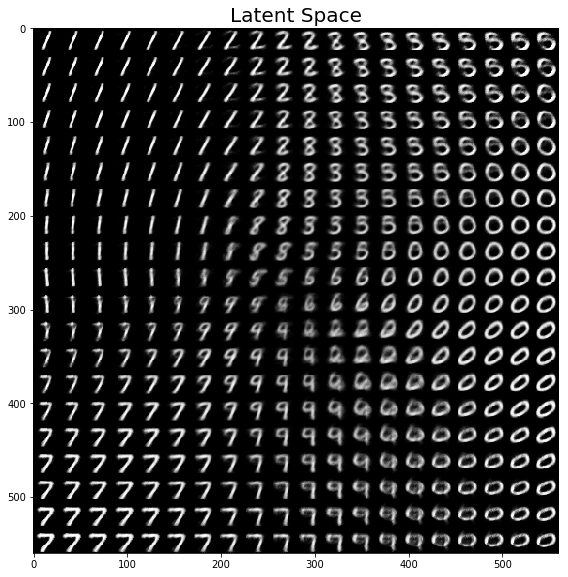

[6/50] recon:[0.262] kl:[0.034].
[7/50] recon:[0.258] kl:[0.035].
[8/50] recon:[0.256] kl:[0.036].
[9/50] recon:[0.253] kl:[0.036].
[10/50] recon:[0.251] kl:[0.037].


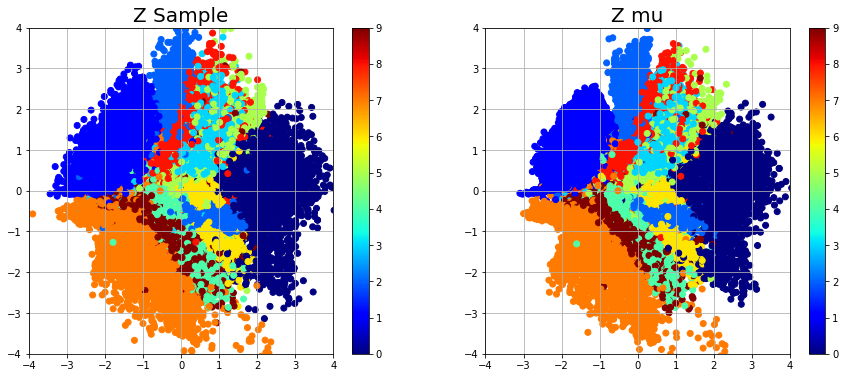

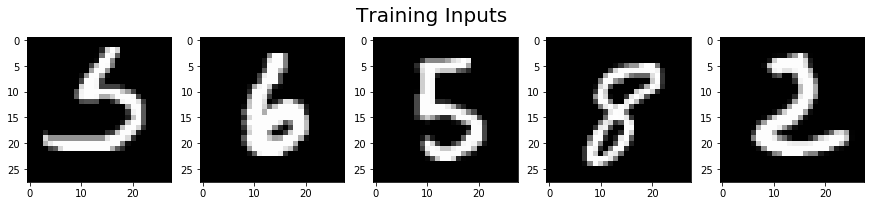

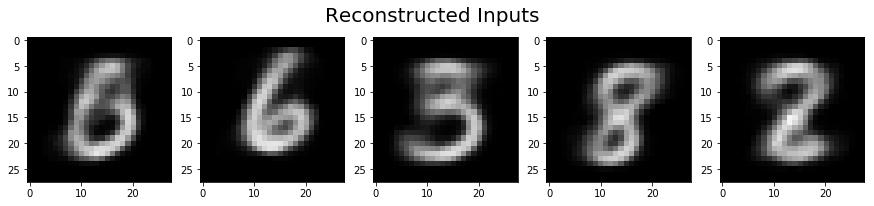

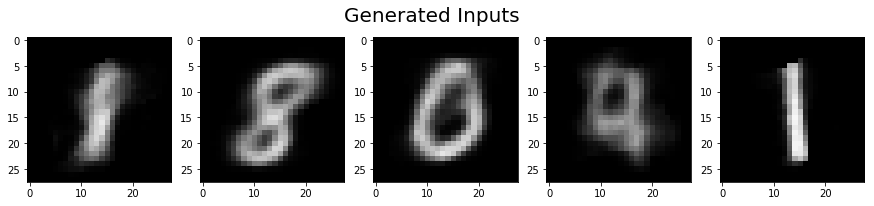

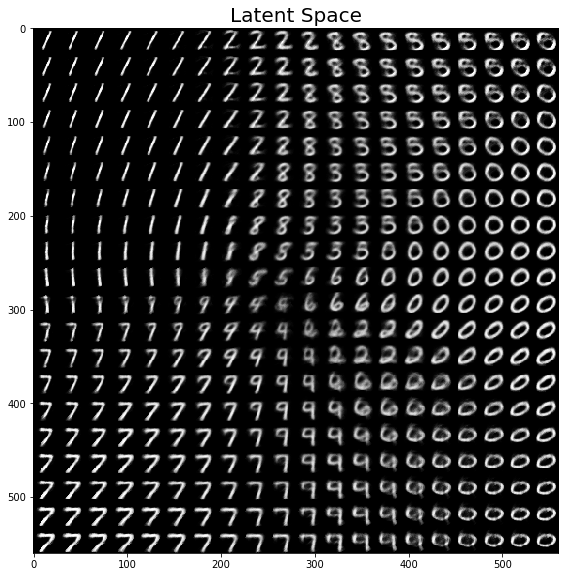

[11/50] recon:[0.248] kl:[0.037].
[12/50] recon:[0.247] kl:[0.037].
[13/50] recon:[0.245] kl:[0.038].
[14/50] recon:[0.244] kl:[0.038].
[15/50] recon:[0.242] kl:[0.038].


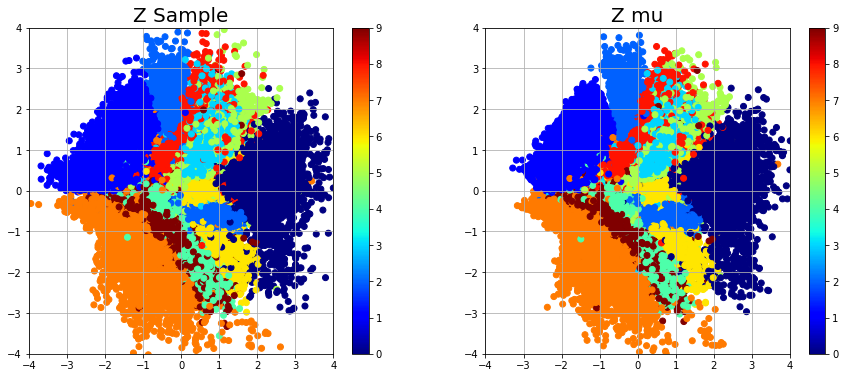

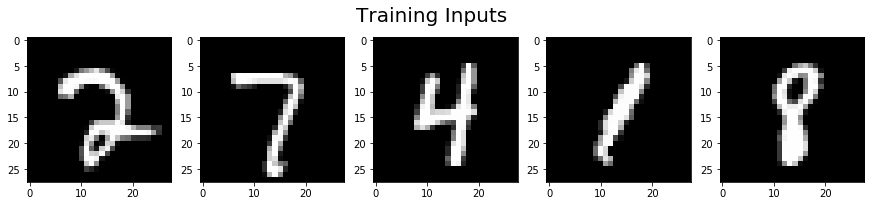

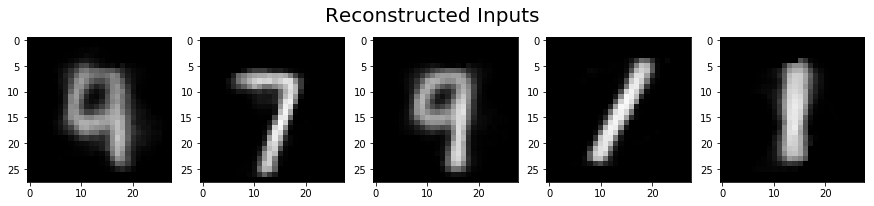

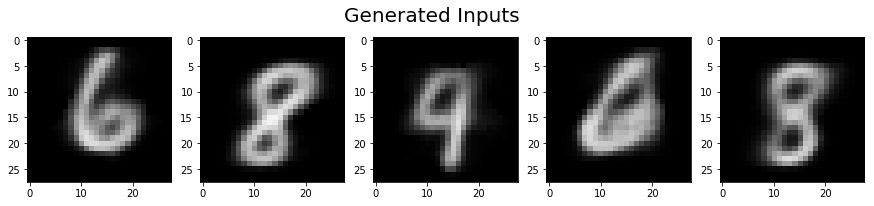

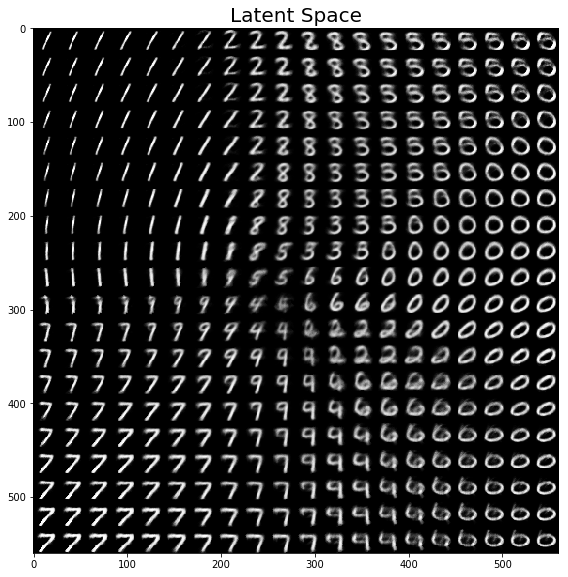

[16/50] recon:[0.241] kl:[0.038].
[17/50] recon:[0.240] kl:[0.039].
[18/50] recon:[0.239] kl:[0.039].
[19/50] recon:[0.238] kl:[0.039].
[20/50] recon:[0.237] kl:[0.039].


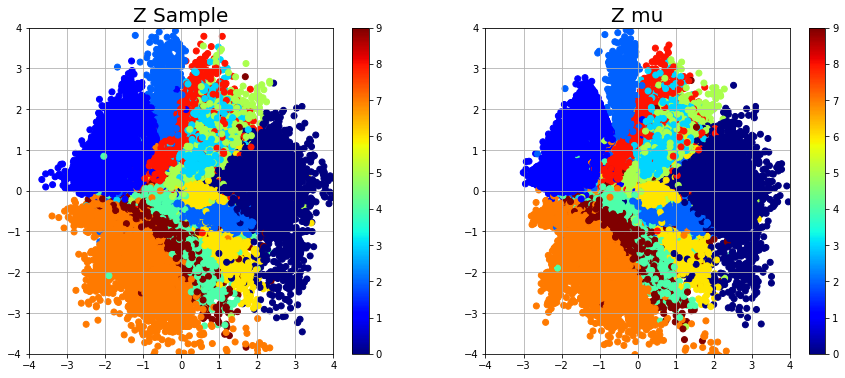

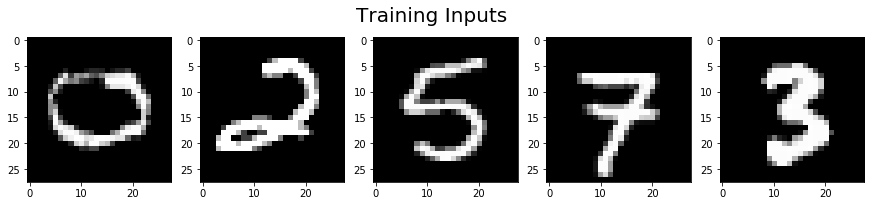

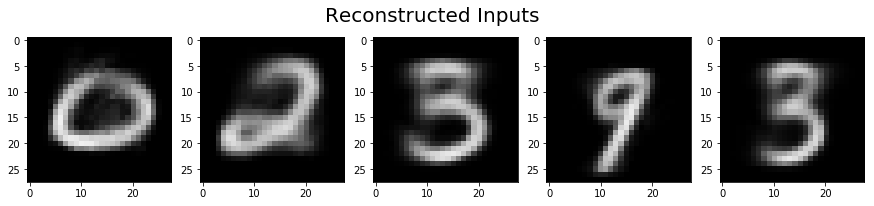

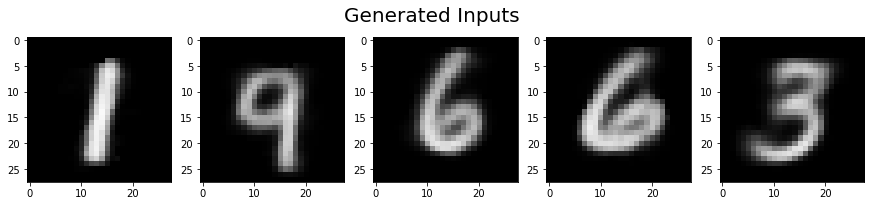

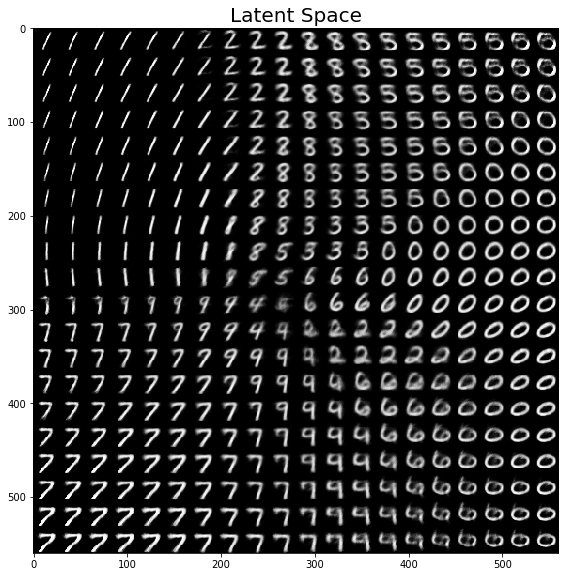

[21/50] recon:[0.236] kl:[0.040].
[22/50] recon:[0.235] kl:[0.040].
[23/50] recon:[0.234] kl:[0.040].
[24/50] recon:[0.233] kl:[0.040].
[25/50] recon:[0.233] kl:[0.040].


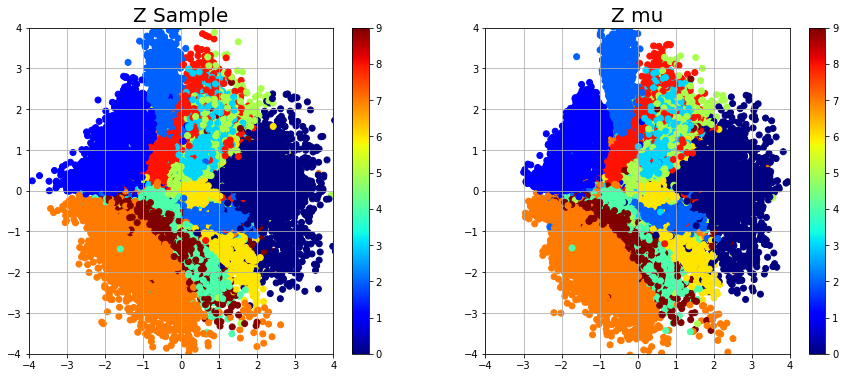

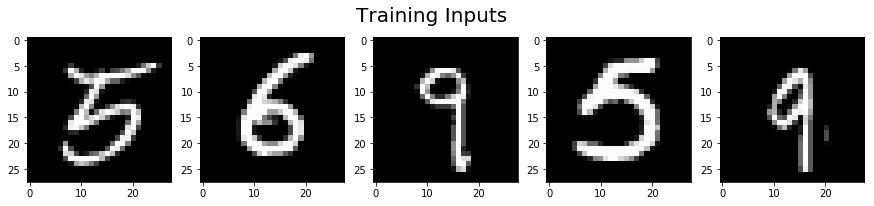

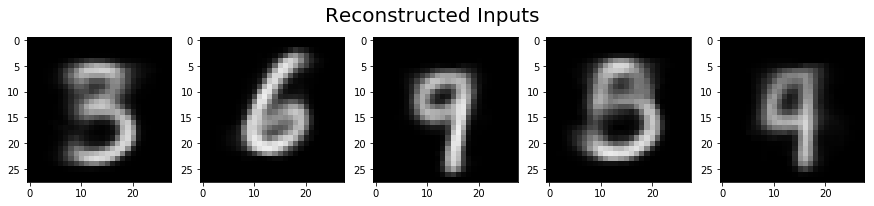

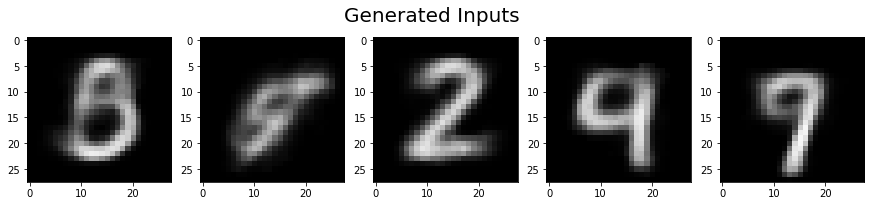

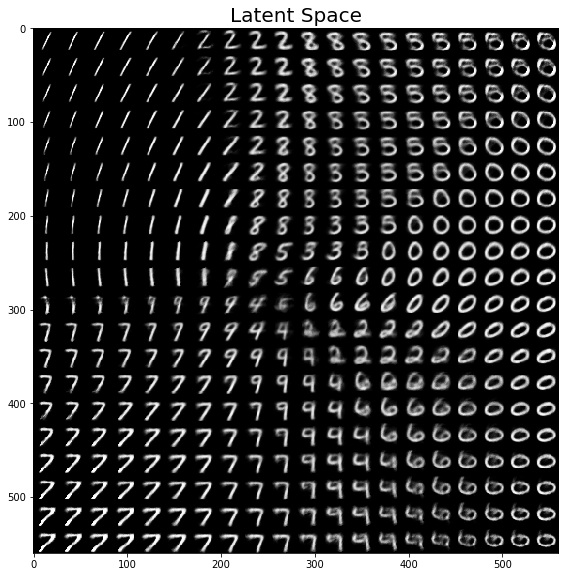

[26/50] recon:[0.232] kl:[0.040].
[27/50] recon:[0.231] kl:[0.041].
[28/50] recon:[0.231] kl:[0.041].
[29/50] recon:[0.230] kl:[0.041].
[30/50] recon:[0.229] kl:[0.041].


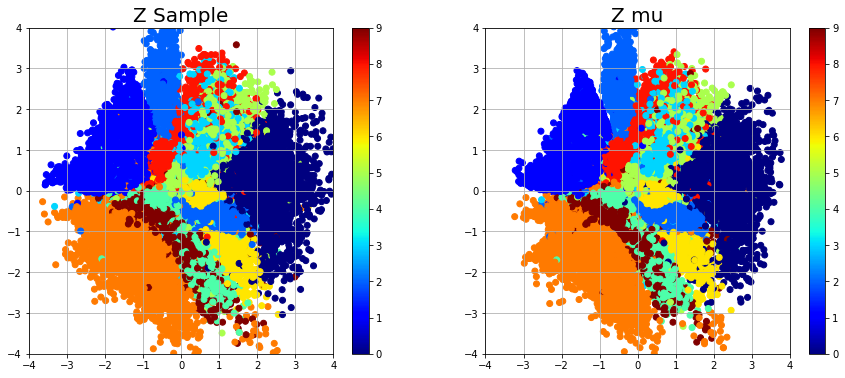

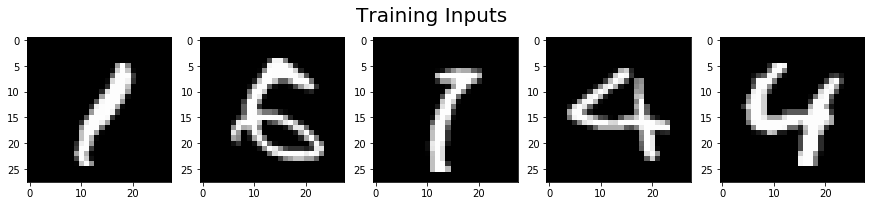

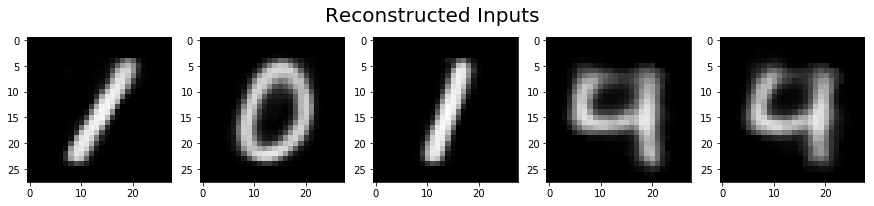

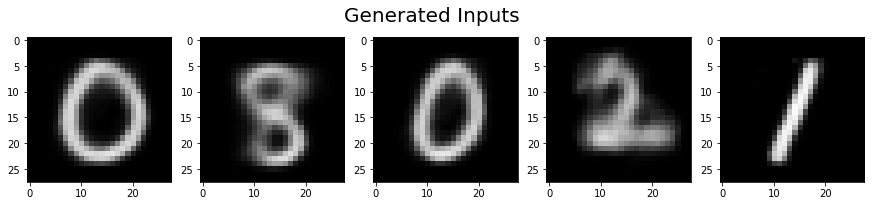

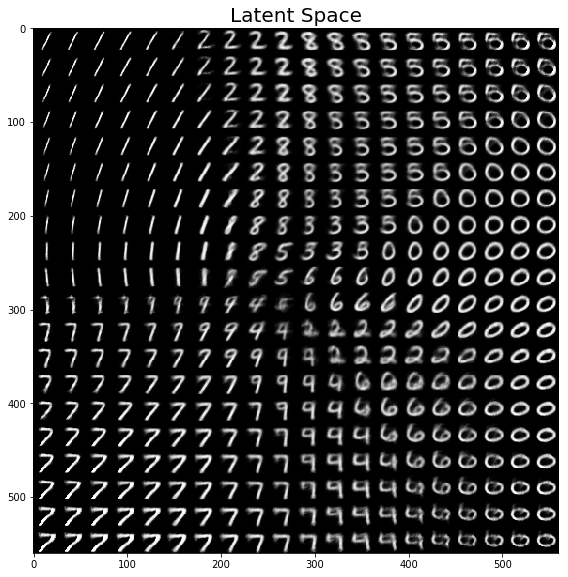

[31/50] recon:[0.229] kl:[0.041].
[32/50] recon:[0.228] kl:[0.041].
[33/50] recon:[0.228] kl:[0.041].
[34/50] recon:[0.228] kl:[0.041].
[35/50] recon:[0.227] kl:[0.041].


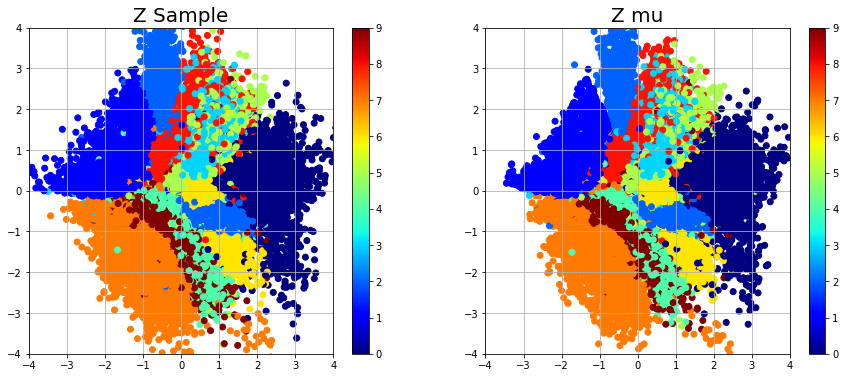

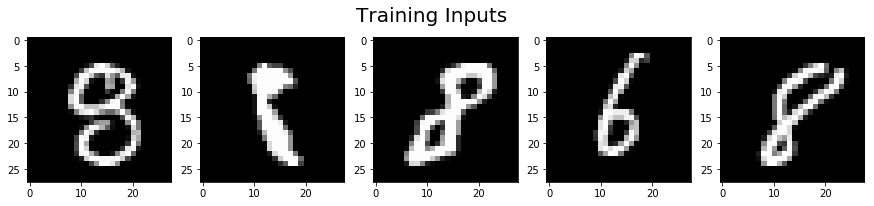

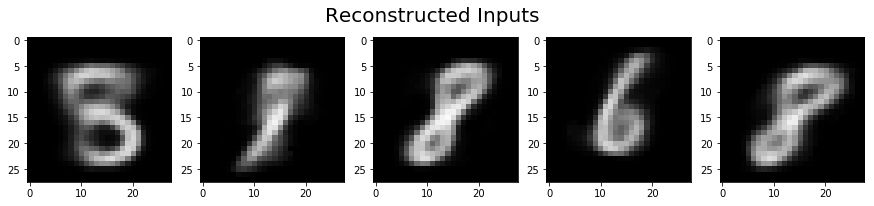

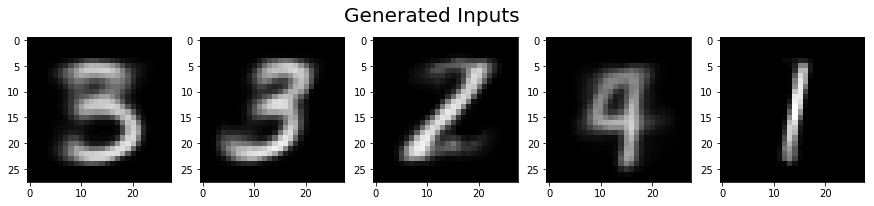

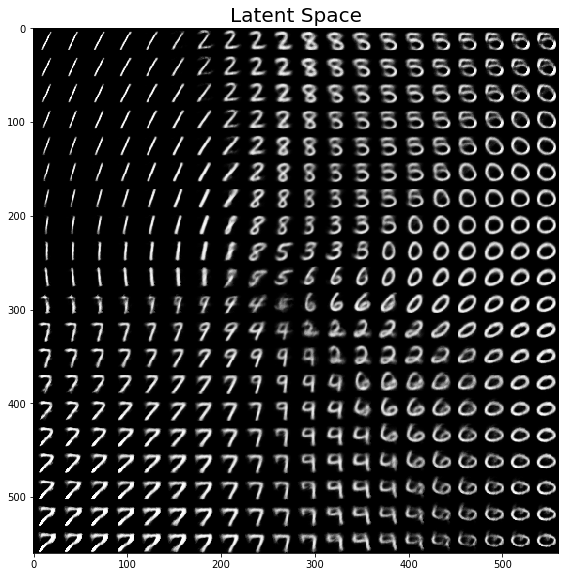

[36/50] recon:[0.226] kl:[0.042].
[37/50] recon:[0.226] kl:[0.042].
[38/50] recon:[0.225] kl:[0.042].
[39/50] recon:[0.225] kl:[0.042].
[40/50] recon:[0.225] kl:[0.042].


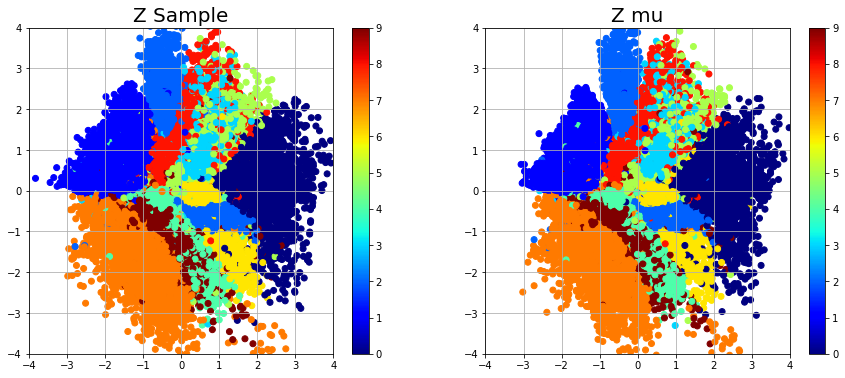

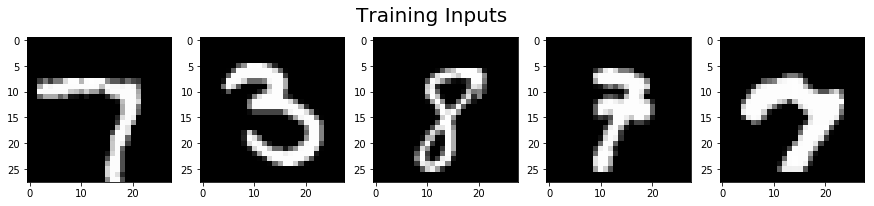

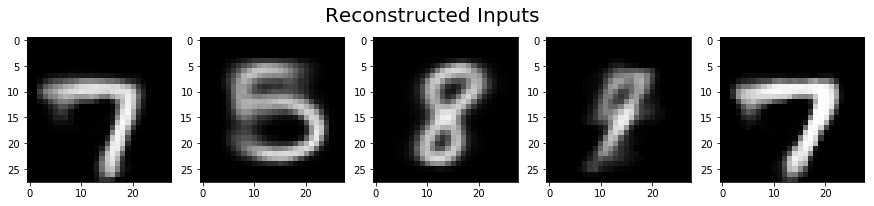

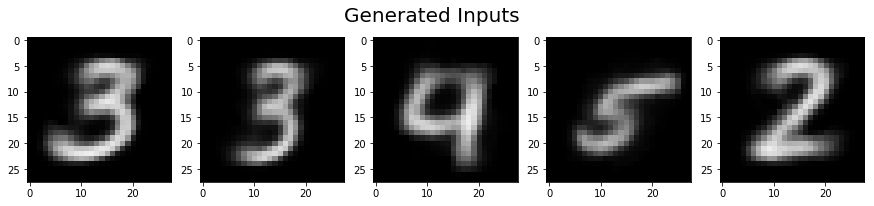

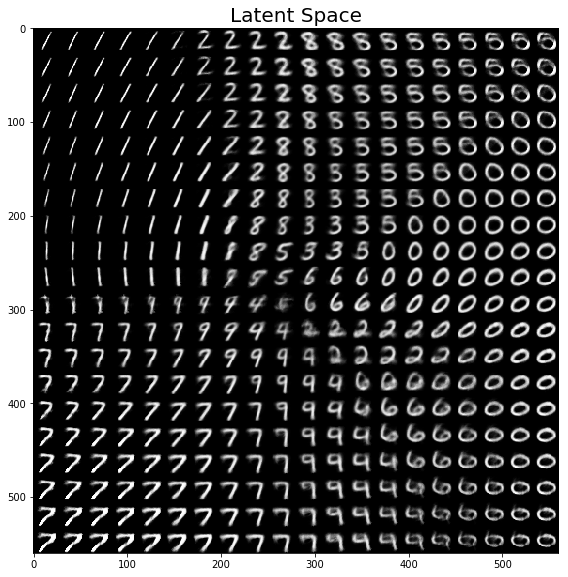

[41/50] recon:[0.224] kl:[0.042].
[42/50] recon:[0.224] kl:[0.042].
[43/50] recon:[0.224] kl:[0.042].
[44/50] recon:[0.224] kl:[0.042].
[45/50] recon:[0.223] kl:[0.042].


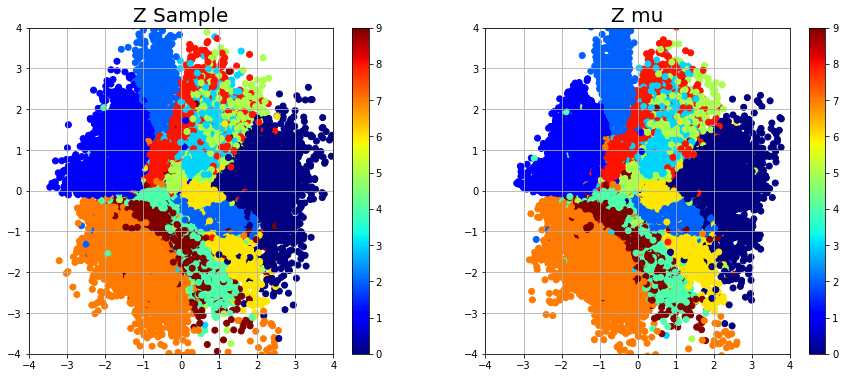

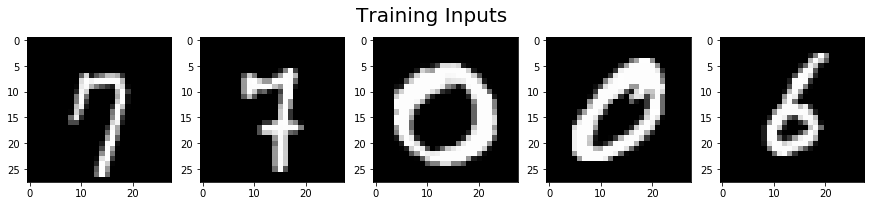

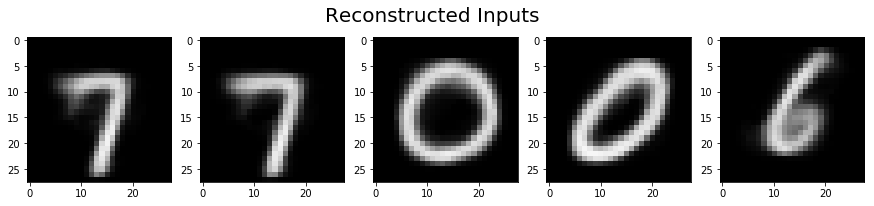

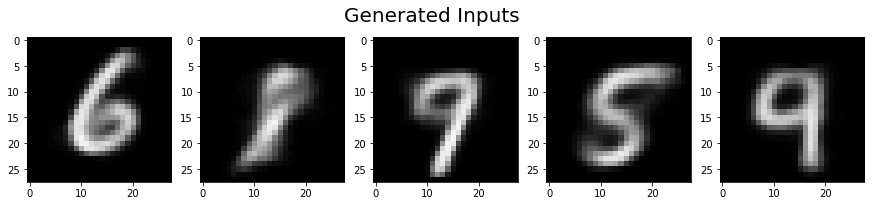

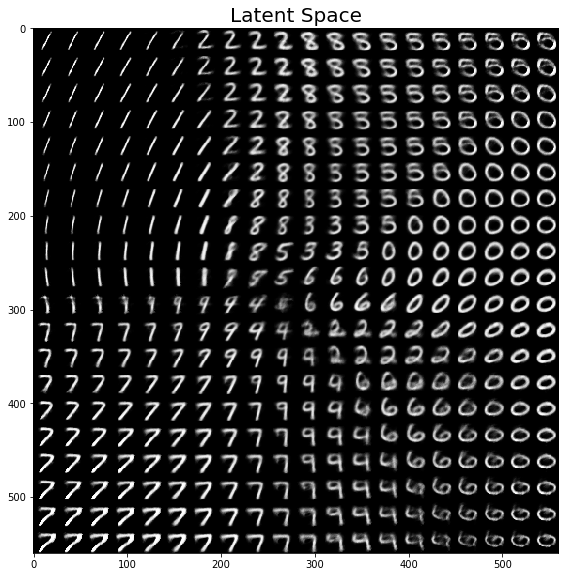

[46/50] recon:[0.222] kl:[0.042].
[47/50] recon:[0.222] kl:[0.042].
[48/50] recon:[0.222] kl:[0.042].
[49/50] recon:[0.222] kl:[0.043].


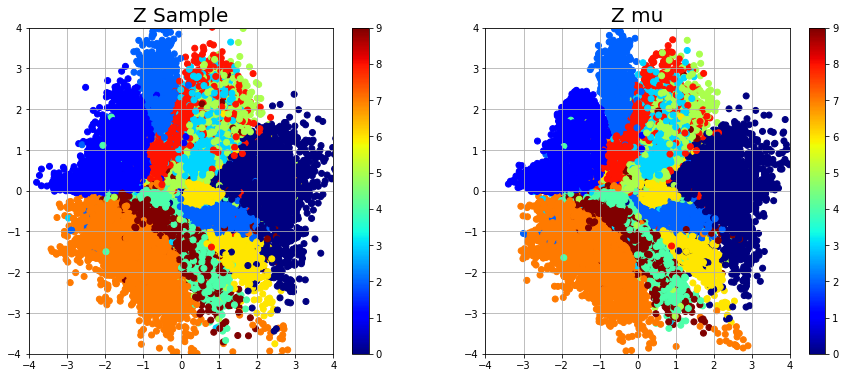

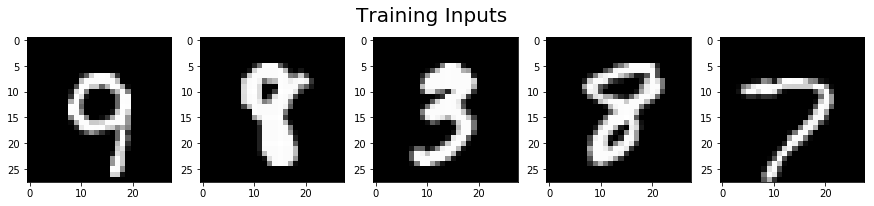

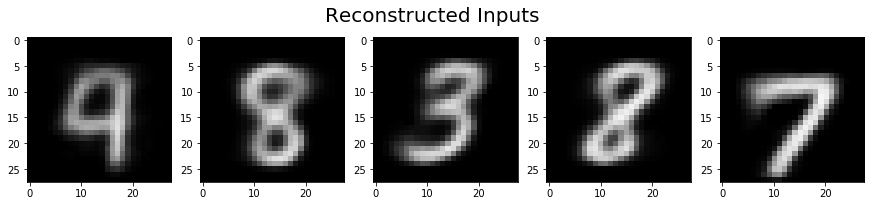

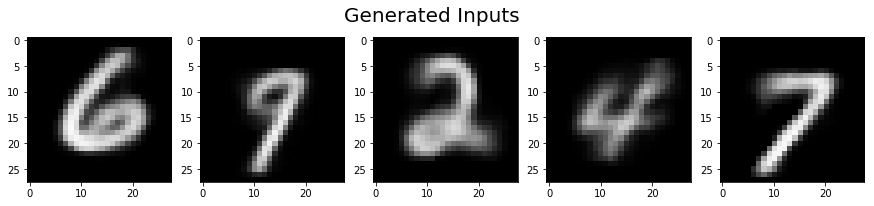

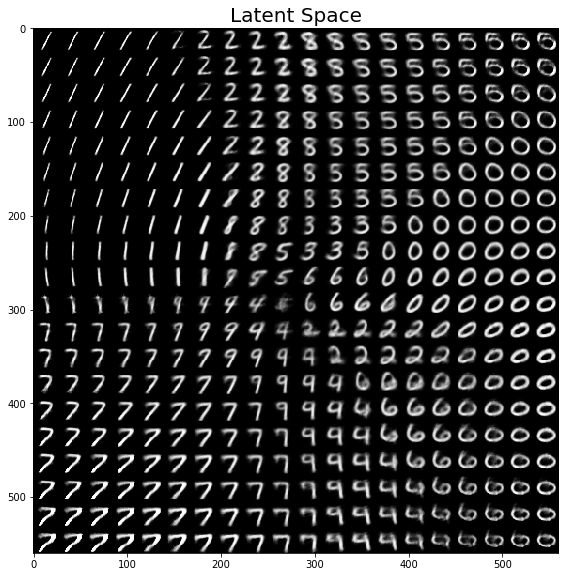

Done.


In [5]:
sess.run(tf.global_variables_initializer())
n_epoch,batch_size,plot_every = 50,128,5
for e in range(n_epoch):
    randperm_idxs = np.random.permutation(n)
    recon_loss_val_sum,kl_loss_val_sum = 0.0,0.0
    for it in range(n//batch_size):
        batch_idx = randperm_idxs[it*batch_size:(it+1)*batch_size]
        x_batch = x[batch_idx,:]
        recon_loss_val,kl_loss_val = V.update(sess,x_batch=x_batch,lr=1e-3)
        recon_loss_val_sum += recon_loss_val
        kl_loss_val_sum += kl_loss_val
    recon_loss_val_avg,kl_loss_val_avg = recon_loss_val_sum/n,kl_loss_val_sum/n
    print ("[%d/%d] recon:[%.3f] kl:[%.3f]."%
           (e,n_epoch,recon_loss_val_avg,kl_loss_val_avg))
    
    if ((e % plot_every) == 0) or ((e+1) == n_epoch):
        # Get z_sample, z_mu, and x_recon
        feed_dict = {V.x_real:x}
        z_sample,z_mu,x_recon = sess.run([V.z_sample,V.z_mu,V.x_recon],feed_dict=feed_dict)

        # Plot z sample and z mu 
        plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.scatter(z_sample[:,0],z_sample[:,1],c=y,cmap='jet')
        plt.title('Z Sample',fontsize=20);plt.colorbar();plt.grid()
        plt.xlim([-4,4]); plt.ylim([-4,4]);
        plt.subplot(1,2,2)
        plt.scatter(z_mu[:,0],z_mu[:,1],c=y,cmap='jet')
        plt.title('Z mu',fontsize=20);plt.colorbar();plt.grid()
        plt.xlim([-4,4]); plt.ylim([-4,4]);plt.show()

        # Plot input and reconstructed inputs
        n_sample = 5
        randperm_idxs = np.random.permutation(n)[:n_sample]
        fig = plt.figure(figsize=(15,3))
        for i in range(n_sample):
            plt.subplot(1,n_sample,i+1)
            plt.imshow(x[randperm_idxs[i],:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
        fig.suptitle("Training Inputs",fontsize=20);plt.show()
        
        fig = plt.figure(figsize=(15,3))
        for i in range(n_sample):
            plt.subplot(1,n_sample,i+1)
            plt.imshow(x_recon[randperm_idxs[i],:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
        fig.suptitle("Reconstructed Inputs",fontsize=20);plt.show()

        # Plot generated inputs
        z = np.random.randn(n_sample,V.zdim)
        feed_dict = {V.z_real:z}
        x_gen = sess.run(V.x_decode,feed_dict=feed_dict)
        fig = plt.figure(figsize=(15,3))
        for i in range(n_sample):
            plt.subplot(1,n_sample,i+1)
            plt.imshow(x_gen[i,:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
        fig.suptitle("Generated Inputs",fontsize=20);plt.show()

        # Plot the latent space
        nx = ny = 20
        x_values,y_values = np.linspace(-3,3,nx),np.linspace(-3,3,ny)
        canvas = np.empty((28*ny, 28*nx))
        for i, yi in enumerate(x_values):
            for j, xi in enumerate(y_values):
                feed_dict = {V.z_real:np.array([[xi, yi]])}
                x_gen = sess.run(V.x_decode,feed_dict=feed_dict)
                canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_gen[0].reshape(28, 28)
        plt.figure(figsize=(8, 10))        
        Xi, Yi = np.meshgrid(x_values, y_values)
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.title("Latent Space",fontsize=20);plt.tight_layout();plt.show()

print ("Done.")